### To Do Later:
 - The pdf converter needs serious help. I'm going to need to find a different converter to use
 - Ask the user if text needs to be rotated
 - Play with Regex more to make sure it is only grabbing page numbers
 - Try increasing accuracy with page numbers either by using Azure's "Read" API, or by running several different OCRs from different frameworks.
 - Take the Azure key out of this file and find some better way to secure it
 
#### Other thoughts
 - We could save a lot on our monthly processing limits if we can find a way to narrow down the pages we need to search

# Notes
 - Azure limits image files to maximum dimensions of 4200 x 4200. Most plan pdfs are bigger than that. They will need to be sized down when converting pdf to image.
 - PNG files will be easier to read than JPEG files.
 - Our Azure OCR subscription is limited at 20 images per second. So when the program hits that limit, it waits a few seconds and tries again (with exponential backoff).


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import io
import os
import re
import time
from functools import wraps
# import pdf2image # This is a library that will probably need to be installed with pip
from PIL import Image, ImageDraw

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import ComputerVisionErrorException
from msrest.authentication import CognitiveServicesCredentials
%matplotlib inline

In [2]:
# This function is currently unreliable
# def convert_pdf_to_png(pdf_path, output_folder, output_file, first_page=None, last_page=None):
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)
    
#     pdf2image.convert_from_path(pdf_path, 
#                                 output_folder=output_folder, 
#                                 first_page=first_page, 
#                                 last_page=last_page, 
#                                 fmt='png', 
#                                 size=(None, 4500), 
#                                 output_file=output_file)

def retry(exceptions, tries=6, delay=5, backoff=1.5, logger=None):
    """
    Retry calling the decorated function using an exponential backoff.

    Args:
        exceptions: The exception to check. may be a tuple of
            exceptions to check.
        tries: Number of times to try (not retry) before giving up.
        delay: Initial delay between retries in seconds.
        backoff: Backoff multiplier (e.g. value of 2 will double the delay
            each retry).
        logger: Logger to use. If None, print.
    """
    def deco_retry(f):
        @wraps(f)
        def f_retry(*args, **kwargs):
            mtries, mdelay = tries, delay
            while mtries > 1:
                try:
                    return f(*args, **kwargs)
                except exceptions as e:
                    msg = '{}, Retrying in {:.0f} seconds...'.format(e, mdelay)
                    if logger:
                        logger.warning(msg)
                    else:
                        print(msg)
                    time.sleep(mdelay)
                    mtries -= 1
                    mdelay *= backoff
            return f(*args, **kwargs)
        return f_retry  # true decorator
    return deco_retry
    
    
class PlanTextExtractor:
    '''Extracts text from an entire plan, and provides functionality to link tags to graphics
    
    Note that a plan needs to converted from pdf to .png with each page its own image, 
    and stored in the same folder.
    
    Attributes:
        plan_folder_path (str): The folder containing the plan images
        results (dict{str:list}): All the processed text and textboxes for each image, with filenames as keys
        page_nums (dict{str:str}): Dict of filenames, with page nums as keys
        detail_graphic_bboxes (dict{str:list}): The detail graphic bounding boxes for each file
        
    Methods:
        get_text_in_bbox: Returns text contained within a bounding box within an image
        get_page_nums: Finds the page num for each image in the plan
        process_detail_tag: Returns the page num and detail number for a detail tag within a bounding box
        get_detail_graphic_bbox: Locates the corresponding detail graphic given a page num and detail number
                                NOTE: This method is currently hard coded
        crop_bbox: Crops a bbox from an image
        get_detail_graphic_from_tag: Given a detail tag, returns a cropped image of the detail graphic
    '''
    
    def __init__(self, plan_folder_path, pg_num_bbox, process_all_pages=True, master_dict=None):
        '''Initialize class, process all text in the plan, and get page nums
        
        Args:
            plan_folder_path (str): The folder containing the plan images
            pg_num_bbox (list[int]): The bounding box where the page number can be found throughout the plan
            process_all_pages (bool): Currently always true. Could modify later to process only a selection of pages
            master_dict (bool): Used to bypass the call to Azure to save processing if running again in same instance
        '''
        self.plan_folder_path = plan_folder_path
        self.results = {}
        self.detail_graphic_bboxes = {}
        
        # Bypasses the call to Azure using stored info
        if master_dict: 
            process_all_pages = False
            self.results = master_dict
            
        # Load in all of the pages in the plan
        if process_all_pages:
            cog_key = input('Please enter the Azure API key: ')
            cog_endpoint = 'https://tag-linking.cognitiveservices.azure.com/'

            # Get a client for the computer vision service
            computervision_client = ComputerVisionClient(cog_endpoint, CognitiveServicesCredentials(cog_key))

            for i, img_name in enumerate(os.listdir(self.plan_folder_path)):
                if img_name.endswith('.png'):
                    print('Processing image {} of ~{}'.format(i+1, len(os.listdir(self.plan_folder_path))))

                    # Use the Computer Vision service to find text in the image
                    @retry(ComputerVisionErrorException)
                    def run_azure_ocr(plan_folder_path, img_name):
                        image_path = plan_folder_path + '/' + img_name
                        image_stream = open(image_path, "rb")
                        return computervision_client.recognize_printed_text_in_stream(image_stream)
                    read_results = run_azure_ocr(plan_folder_path, img_name)
                    
                    # Store the text bboxes
                    result_bboxes = {}
                    for region in read_results.regions:
                        for line in region.lines:
                            l,t,w,h = tuple(map(int, line.bounding_box.split(',')))
                            bbox = (l, t, l+w, t+h)
                            line_text = ''
                            for word in line.words:
                                line_text += word.text + ' '
                            clean_line = line_text.rstrip()
                            result_bboxes[bbox] = clean_line
                    self.results[img_name] = result_bboxes
                    
                    self.detail_graphic_bboxes[img_name] = []
                    
            print('Finished processing all images')
        self.page_nums = self.get_page_nums(pg_num_bbox)
        
    def get_text_in_bbox(self, filename, target_bbox):
        '''Returns text contained within a bounding box on an image

        Args:
            filename (str): Image file to process (.png)
            target_bbox (tuple(int)): Coordinates of the bounding box (left, top, right, bottom)

        Returns:
            contained_text_boxes (list[tuple(tuple(int), str)]): Text boxes and text found within the target bounding box
        '''
        target_left, target_top, target_right, target_bottom = target_bbox
        contained_text_bboxes = []
        
        for text_bbox, text in self.results[filename].items():
            text_left, text_top, text_right, text_bottom = text_bbox
            
            left_contained = (target_left <= text_left <= target_right)
            top_contained = (target_top <= text_top <= target_bottom)
            right_contained = (target_left <= text_right <= target_right)
            bottom_contained = (target_top <= text_bottom <= target_bottom)
            edges_contained = left_contained + top_contained + right_contained + bottom_contained
            
            if edges_contained == 4: # This could be changed if you just wanted text bboxes intersecting with the target
                contained_text_bboxes.append([text_bbox, text])

        return contained_text_bboxes
    
    def get_page_nums(self, pg_num_bbox):
        '''Checks the given bounding box on each page of the plan for a page number
        
        Args:
            pg_num_bbox (list[int]): A bounding box containing the page number (assumed to be the same box on each page)
            
        Returns:
            page_nums (dict{str:str}): Dict of filenames, with page nums as keys 
        '''
        pattern = re.compile(r'^[A-Za-z]{1,2}\s?[\dIOo]{1,4}(\.*\d{1,3}[A-Za-z]?)?([\s\-]OPT)?$')
        page_nums = {}
        
        for filename in self.results.keys():
            text_boxes = self.get_text_in_bbox(filename, pg_num_bbox)
            
            candidates = []
            candidate_bboxes = []
            for (bbox, text) in text_boxes:
                if pattern.match(text):
                    candidates.append(text)
                    candidate_bboxes.append(bbox)
            if len(candidates) == 0:
                print('No page num captured for {}'.format(filename))
            else:   
                # If there are multiple candidates, find the one with the largest bbox
                if len(candidates) != 1:
                    box_areas = []
                    for bbox in candidate_bboxes:
                        area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
                        box_areas.append(area)
                    page_num = candidates[np.argmax(np.array(box_areas))]
                else:
                    page_num = candidates[0]
                opt_page = False
                if page_num[-3:] == 'OPT':
                    opt_page = True
                    page_num = page_num[:-3]
                page_nums[page_num.upper()] = filename
                page_num = page_num.upper()
                page_num = page_num.replace('I', '1')
                page_num = page_num.replace('O', '0')
                page_num = page_num.replace(' ', '')
                page_num += 'OPT' if opt_page else ''
                page_nums[page_num] = filename
            
        return page_nums
    
    def process_detail_tag(self, filename, tag_bbox):
        '''Return the page number and detail number for a detail tag
        
        Args:
            filename (str): The file the detail tag is on
            tag_bbox (list[int]): The bounding box containing the detail tag
        
        Returns:
            page_num (str): The page number conaining the detail graphic
            detail_num (str): The number for the detail graphic
        '''
        textboxes = self.get_text_in_bbox(filename, tag_bbox)
        if len(textboxes) != 2:
            print(textboxes)
            raise ValueError('Found incorrect number of text boxes for detail tag')
        else:
            text1 = textboxes[0][1]
            text2 = textboxes[1][1]
            
        if text2 in self.page_nums.keys():
            page_num = text2
            detail_num = text1
        else:
            page_num = text1
            detail_num = text2
        return page_num, detail_num
    
    def add_detail_graphic_bbox(self, filename, detail_bbox, number_bbox):
        '''Add a bounding box for a detail graphic for a specific file
        
        Args:
            filename (str): The file that the detail graphic is in
            detail_bbox (list[int]): The bounding box for the detail graphic
            number_bbox (list[int]): The bounding box for the detail graphic number
        '''
        self.detail_graphic_bboxes[filename].append((detail_bbox, number_bbox))
    
    def get_detail_graphic_bbox(self, page_num, detail_num):
        '''Locates the detail graphic corresponding to the page and detail number
        
        Args:
            page_num (str): The page number where the detail graphic can be found
            detail_num (str): The number for the detail graphic
            
        Returns:
            graphic_bbox (list[int]): The bounding box for the located detail graphic
        '''
        filename = self.page_nums[page_num]
        
        if not self.detail_graphic_bboxes:
            raise ValueError('The file "{}" has no detail graphic bboxes'.format(filename))
            
        for graphic_bbox, number_bbox in self.detail_graphic_bboxes[filename]:
            contained_text = self.get_text_in_bbox(filename, number_bbox)
            if len(contained_text) > 1:
                raise ValueError('Multiple pieces of text for detail number')
            if contained_text:
                text_bbox, text = contained_text[0]
                if text == detail_num:
                    return graphic_bbox
            
        raise Exception('Unable to find corresponding detail graphic on page')
        
    def crop_bbox(self, filename, bbox):
        '''Returns a PIL Image cropped to a bounding box'''
        image_path = self.plan_folder_path + '/' + filename
        orig_img = Image.open(image_path)
        return orig_img.crop(bbox)
    
    def get_detail_graphic_from_tag(self, filename, tag_bbox):
        '''Returns a cropped image of a detail graphic corresponding to the given detail tag
        
        Args:
            filename (str): The file that contains the detail tag
            tag_bbox (list[int]): The bounding box for the detail tag
            
        Returns:
            (PIL Image): Cropped image of detail graphic
        '''
        page_num, detail_num = self.process_detail_tag(filename, tag_bbox)
        detail_bbox = self.get_detail_graphic_bbox(page_num, detail_num)
        return self.crop_bbox(self.page_nums[page_num], detail_bbox)

In [ ]:
pdf_path = 'the_view.pdf'

project_name = 'the_view'
plan_folder_path = 'full_plans/' + project_name
pg_num_bbox = (3645, 2376, 4050, 2700)

# Process all of the text in the plan
the_view = PlanTextExtractor(plan_folder_path, pg_num_bbox)

# # Update the object without processing all of the text again (only used for debugging)
# the_view = PlanTextExtractor(plan_folder_path, pg_num_bbox, master_dict=master_dict)
# the_view.detail_graphic_bboxes = saved_graphic_bboxes

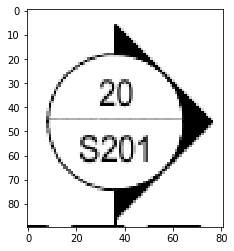

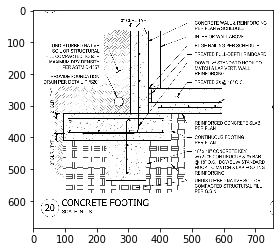

In [4]:
filename = 'the_view0001-12.png'

# Bounding box for pg12
left = 927
top = 626
right = 1008
bottom = 716
tag_bbox1 = (left, top, right, bottom)
tag_bbox2 = (2080, 1290, 2175, 1370)

# Show the detail tag, just for fun
cropped_tag = the_view.crop_bbox(filename, tag_bbox1)
plt.figure()
plt.imshow(cropped_tag)
cropped_tag.show()

# Input detail graphic bboxes
num_rows = 4
num_cols = 5
start_left = 108
start_top = 67
start_right = 825
start_bottom = 712
width = start_right - start_left
height = start_bottom - start_top
starting_center = [start_left + width/2, start_top + height/2]
detail_bboxes = []
center = starting_center.copy()
padding = 20
for row in range(num_rows):
    for col in range(num_cols):
        left = center[0] - width/2 - padding
        top = center[1] - height/2 - padding
        right = center[0] + width/2 + padding
        bottom = center[1] + height/2 + padding
        detail_bbox = [left, top, right, bottom]
        number_bbox = [left, bottom - 80 - padding, left + 80 + padding, bottom]
        detail_bboxes.append((detail_bbox, number_bbox))
        center[0] += width
    center[1] += height
    center[0] = starting_center[0]

detail_pages = ['the_view0001-20.png', 'the_view0001-21.png', 'the_view0001-22.png', 'the_view0001-23.png',]
for file in detail_pages:
    for bbox in detail_bboxes:
        the_view.add_detail_graphic_bbox(file, bbox[0], bbox[1])
    
cropped_graphic = the_view.get_detail_graphic_from_tag(filename, tag_bbox1)
plt.figure()
plt.imshow(cropped_graphic)
cropped_graphic.show()
plt.show()

In [5]:
# master_dict = the_view.results
# saved_graphic_bboxes = the_view.detail_graphic_bboxes

In [6]:
# filename = 'the_view_structure_pages0001-15.png'
# image_path = 'full_plans/the_view_structure_pages/' + filename

# # Open image to display it.
# fig = plt.figure(figsize=(7, 7))
# img = Image.open(image_path)
# draw = ImageDraw.Draw(img)

# # print(the_view.results[filename])

# # Process the text line by line
# for (l,t,r,b), text in the_view.results[filename].items():
#     # Show the position of the line of text
#     draw.rectangle(((l,t), (r, b)), outline='magenta', width=2)

    
# # draw.rectangle(tag_bbox2, outline='green', width=5)    
# # Show the image with the text locations highlighted
# plt.axis('off')
# plt.imshow(img)
# img.show()